In [31]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential,Model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,  BatchNormalization, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import shutil
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import MobileNetV2
import imghdr

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

In [32]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Step 1: Load and Preprocess Images

In [33]:
class RegressionDataLoader:
    def __init__(self, data_path='./Materials_data'):
        self.data_path = data_path
        self.param_scaler = MinMaxScaler()
        
    def extract_parameters_from_folder(self, folder_name):
        """Extract continuous parameters from folder name format: 1-20.20.20.20-1"""
        try:
            # Remove any prefix before the first number
            parts = folder_name.split('-')
            if len(parts) >= 2:
                # Extract the parameter string (e.g., "20.20.20.20")
                param_str = parts[1]
                # Split into individual parameters
                params = [float(x) for x in param_str.split('.')]
                if len(params) == 4:
                    return params  # [弯曲强度, 强度, 形变强度, 形变率]
        except:
            pass
        return None
    
    def load_dual_view_images(self, folder_path):
        """Load top-view (-1) and side-view (-2) images from folder"""
        top_images = []
        side_images = []
        
        # Find all image files in folder
        if not os.path.exists(folder_path):
            return [], []
            
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                if filename.endswith('-1.jpg'):
                    # Top view image
                    img_path = os.path.join(folder_path, filename)
                    try:
                        img = load_img(img_path, target_size=(224, 224))
                        img_array = img_to_array(img) / 255.0
                        top_images.append(img_array)
                    except:
                        continue
                elif filename.endswith('-2.jpg'):
                    # Side view image
                    img_path = os.path.join(folder_path, filename)
                    try:
                        img = load_img(img_path, target_size=(224, 224))
                        img_array = img_to_array(img) / 255.0
                        side_images.append(img_array)
                    except:
                        continue
        
        return top_images, side_images
    
    def load_regression_data(self):
        """Load all data for regression training"""
        top_images = []
        side_images = []
        parameters = []
        folder_names = []
        
        print("Loading regression data from folder structure...")
        
        # Scan all folders in data path
        for folder_name in os.listdir(self.data_path):
            folder_path = os.path.join(self.data_path, folder_name)
            
            if not os.path.isdir(folder_path):
                continue
                
            # Extract parameters from folder name
            params = self.extract_parameters_from_folder(folder_name)
            if params is None:
                continue
                
            # Load images from this folder
            folder_top_images, folder_side_images = self.load_dual_view_images(folder_path)
            
            # Match top and side images (assuming same count)
            min_count = min(len(folder_top_images), len(folder_side_images))
            
            for i in range(min_count):
                top_images.append(folder_top_images[i])
                side_images.append(folder_side_images[i])
                parameters.append(params)
                folder_names.append(folder_name)
                
        # Convert to numpy arrays
        top_images = np.array(top_images) if top_images else np.array([])
        side_images = np.array(side_images) if side_images else np.array([])
        parameters = np.array(parameters) if parameters else np.array([])
        
        if len(parameters) > 0:
            # Normalize parameters to [0,1] range for training
            parameters_normalized = self.param_scaler.fit_transform(parameters)
        else:
            parameters_normalized = np.array([])
        
        print(f"Loaded {len(top_images)} samples")
        if len(parameters) > 0:
            print(f"Parameter ranges: {np.min(parameters, axis=0)} to {np.max(parameters, axis=0)}")
        print(f"Parameter names: ['弯曲强度', '强度', '形变强度', '形变率']")
        
        return top_images, side_images, parameters_normalized, parameters, folder_names

# Test the data loader
data_loader = RegressionDataLoader()
top_imgs, side_imgs, params_norm, params_orig, folders = data_loader.load_regression_data()

# Display sample
if len(top_imgs) > 0:
    print(f"\nSample data:")
    print(f"Top image shape: {top_imgs[0].shape}")
    print(f"Side image shape: {side_imgs[0].shape}")
    print(f"Parameters (original): {params_orig[0]}")
    print(f"Parameters (normalized): {params_norm[0]}")
    print(f"Folder: {folders[0]}")
else:
    print("\nNo regression data found. Check folder structure.")

Loading regression data from folder structure...
Loaded 147 samples
Parameter ranges: [ 0. 20. 20. 20.] to [100. 100.  60.  20.]
Parameter names: ['弯曲强度', '强度', '形变强度', '形变率']

Sample data:
Top image shape: (224, 224, 3)
Side image shape: (224, 224, 3)
Parameters (original): [  0. 100.  40.  20.]
Parameters (normalized): [0.  1.  0.5 0. ]
Folder: 10-0.100.40.20-1


# Step 2: Create Simple Regression Model

In [34]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Concatenate, Multiply, Attention
from tensorflow.keras.models import Model

def create_patent_regression_model():
    """
    Create dual-view regression model based on patent methodology
    Predicts continuous parameters: [弯曲强度, 强度, 形变强度, 形变率]
    """
    
    # Input layers for dual-view images
    top_input = Input(shape=(224, 224, 3), name='top_view')
    side_input = Input(shape=(224, 224, 3), name='side_view')
    
    # Shared ResNet50 backbone (transfer learning)
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze initial layers for transfer learning
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    # Extract features from both views
    top_features = base_model(top_input)
    side_features = base_model(side_input)
    
    # Global average pooling
    top_pooled = GlobalAveragePooling2D(name='top_pooled')(top_features)
    side_pooled = GlobalAveragePooling2D(name='side_pooled')(side_features)
    
    # View-specific processing
    top_dense = Dense(256, activation='relu', name='top_dense')(top_pooled)
    top_dense = BatchNormalization()(top_dense)
    top_dense = Dropout(0.3)(top_dense)
    
    side_dense = Dense(256, activation='relu', name='side_dense')(side_pooled)
    side_dense = BatchNormalization()(side_dense)
    side_dense = Dropout(0.3)(side_dense)
    
    # Multi-view fusion with attention mechanism
    combined = Concatenate(name='combined_features')([top_dense, side_dense])
    
    # Attention weights for view importance
    attention_weights = Dense(2, activation='softmax', name='attention_weights')(combined)
    top_weight = attention_weights[:, 0:1]
    side_weight = attention_weights[:, 1:2]
    
    # Apply attention weights
    weighted_top = Multiply()([top_dense, top_weight])
    weighted_side = Multiply()([side_dense, side_weight])
    
    # Final feature fusion
    fused_features = Concatenate()([weighted_top, weighted_side])
    
    # Regression head for parameter prediction
    regression_dense = Dense(512, activation='relu', name='regression_dense')(fused_features)
    regression_dense = BatchNormalization()(regression_dense)
    regression_dense = Dropout(0.4)(regression_dense)
    
    regression_dense2 = Dense(256, activation='relu', name='regression_dense2')(regression_dense)
    regression_dense2 = BatchNormalization()(regression_dense2)
    regression_dense2 = Dropout(0.3)(regression_dense2)
    
    # Output layer: 4 continuous parameters
    output = Dense(4, activation='sigmoid', name='parameter_output')(regression_dense2)
    
    # Create model
    model = Model(
        inputs=[top_input, side_input],
        outputs=output,
        name='patent_regression_model'
    )
    
    return model

# Parameter importance weights from patent
param_weights = np.array([1.0, 0.6, 0.6, 0.3])  # [弯曲强度, 强度, 形变强度, 形变率]

def weighted_mse_loss(y_true, y_pred):
    """Parameter-weighted MSE loss based on patent importance"""
    squared_diff = tf.square(y_true - y_pred)
    weighted_squared_diff = squared_diff * param_weights
    return tf.reduce_mean(weighted_squared_diff)

def weighted_mae_loss(y_true, y_pred):
    """Parameter-weighted MAE loss based on patent importance"""
    abs_diff = tf.abs(y_true - y_pred)
    weighted_abs_diff = abs_diff * param_weights
    return tf.reduce_mean(weighted_abs_diff)

# Create and compile the regression model
regression_model = create_patent_regression_model()

# Compile with parameter-weighted loss functions
regression_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=weighted_mse_loss,
    metrics=[weighted_mae_loss, 'mse', 'mae']
)

# Display model architecture
regression_model.summary()

print("\nModel created for patent-based regression:")
print("- Input: Dual-view images (224x224x3)")
print("- Output: 4 continuous parameters [弯曲强度, 强度, 形变强度, 形变率]")
print("- Loss: Parameter-weighted MSE (patent importance)")
print("- Architecture: ResNet50 + Attention + Regression head")

Model: "patent_regression_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 top_view (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 side_view (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['top_view[0][0]',               
                                                                  'side_view

# Step 3: Create Training Function

TRAINING PATENT-BASED REGRESSION MODEL
Starting patent-based regression training...
Training samples: 147
Parameters per sample: 4
Training set: 117 samples
Validation set: 30 samples

Training configuration:
- Batch size: 16
- Steps per epoch: 7
- Validation steps: 1
- Max epochs: 50
- Parameter weights: [1.  0.6 0.6 0.3]
Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 0.1074 - weighted_mae_loss: 0.2092 - mse: 0.2061 - mae: 0.3692
Epoch 1: val_loss improved from inf to 0.09215, saving model to best_regression_model.h5
7/7 [==============================] - 13s 2s/step - loss: 0.1074 - weighted_mae_loss: 0.2092 - mse: 0.2061 - mae: 0.3692 - val_loss: 0.0921 - val_weighted_mae_loss: 0.1997 - val_mse: 0.1519 - val_mae: 0.3368 - lr: 0.0010
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 0.0909 - weighted_mae_loss: 0.1841 - mse: 0.1748 - mae: 0.3378
Epoch 2: val_loss did not improve from 0.09215
7/7 [==============================] - 8s 1s/step - loss: 0

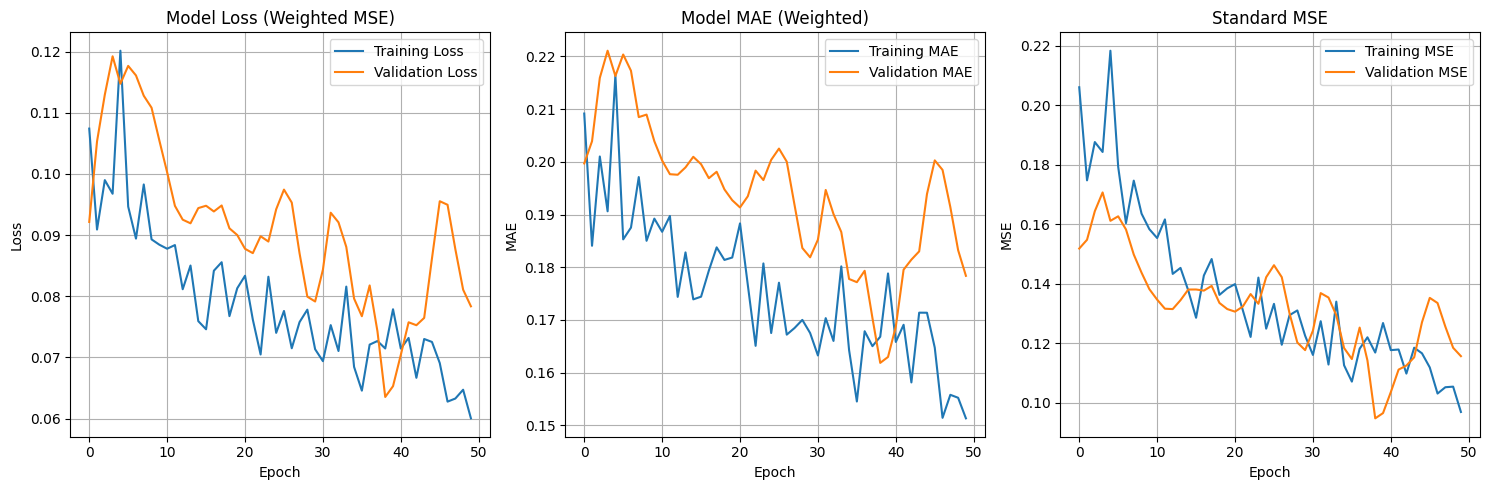

Model saved as: patent_regression_model_final.h5


In [35]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

def train_regression_model(model, top_images, side_images, parameters, validation_split=0.2, epochs=100):
    """
    Train the patent-based regression model
    
    Args:
        model: Compiled regression model
        top_images: Top view images array
        side_images: Side view images array  
        parameters: Normalized parameter values
        validation_split: Fraction for validation
        epochs: Number of training epochs
    """
    
    print("Starting patent-based regression training...")
    print(f"Training samples: {len(top_images)}")
    print(f"Parameters per sample: {parameters.shape[1] if len(parameters) > 0 else 0}")
    
    # Check if we have data
    if len(top_images) == 0 or len(parameters) == 0:
        print("Error: No training data found!")
        return None
    
    # Split data for training and validation
    indices = np.arange(len(top_images))
    train_idx, val_idx = train_test_split(
        indices, 
        test_size=validation_split, 
        random_state=42,
        shuffle=True
    )
    
    # Prepare training data
    X_train_top = top_images[train_idx]
    X_train_side = side_images[train_idx]
    y_train = parameters[train_idx]
    
    # Prepare validation data
    X_val_top = top_images[val_idx]
    X_val_side = side_images[val_idx]
    y_val = parameters[val_idx]
    
    print(f"Training set: {len(X_train_top)} samples")
    print(f"Validation set: {len(X_val_top)} samples")
    
    # Data augmentation for regression training
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    
    # Lighter augmentation for regression (preserve material properties)
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Callbacks for training
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            'best_regression_model.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    # Training generator with augmentation
    def augmented_generator(X_top, X_side, y, batch_size=16):
        """Generate augmented batches for dual-view training"""
        n_samples = len(X_top)
        while True:
            # Shuffle data each epoch
            indices = np.random.permutation(n_samples)
            
            for start in range(0, n_samples, batch_size):
                end = min(start + batch_size, n_samples)
                batch_indices = indices[start:end]
                
                batch_top = X_top[batch_indices]
                batch_side = X_side[batch_indices]
                batch_y = y[batch_indices]
                
                # Apply same augmentation to both views
                seed = np.random.randint(0, 10000)
                
                # Augment top view
                datagen.fit(batch_top, seed=seed)
                aug_top = next(datagen.flow(batch_top, batch_size=len(batch_top), shuffle=False, seed=seed))
                
                # Augment side view with same seed for consistency
                datagen.fit(batch_side, seed=seed)
                aug_side = next(datagen.flow(batch_side, batch_size=len(batch_side), shuffle=False, seed=seed))
                
                yield [aug_top, aug_side], batch_y
    
    # Calculate steps per epoch
    batch_size = 16
    train_steps = len(X_train_top) // batch_size
    val_steps = len(X_val_top) // batch_size
    
    print(f"\nTraining configuration:")
    print(f"- Batch size: {batch_size}")
    print(f"- Steps per epoch: {train_steps}")
    print(f"- Validation steps: {val_steps}")
    print(f"- Max epochs: {epochs}")
    print(f"- Parameter weights: {param_weights}")
    
    # Train the model
    history = model.fit(
        augmented_generator(X_train_top, X_train_side, y_train, batch_size),
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=([X_val_top, X_val_side], y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    return history

# Start training if we have data
if len(top_imgs) > 0:
    print("="*60)
    print("TRAINING PATENT-BASED REGRESSION MODEL")
    print("="*60)
    
    # Train the model
    training_history = train_regression_model(
        regression_model, 
        top_imgs, 
        side_imgs, 
        params_norm,
        validation_split=0.2,
        epochs=50  # Start with fewer epochs for testing
    )
    
    if training_history is not None:
        print("\n" + "="*60)
        print("TRAINING COMPLETED SUCCESSFULLY!")
        print("="*60)
        
        # Plot training history
        plt.figure(figsize=(15, 5))
        
        # Plot loss
        plt.subplot(1, 3, 1)
        plt.plot(training_history.history['loss'], label='Training Loss')
        plt.plot(training_history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss (Weighted MSE)')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        # Plot MAE
        plt.subplot(1, 3, 2)
        plt.plot(training_history.history['weighted_mae_loss'], label='Training MAE')
        plt.plot(training_history.history['val_weighted_mae_loss'], label='Validation MAE')
        plt.title('Model MAE (Weighted)')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
        plt.grid(True)
        
        # Plot standard MSE
        plt.subplot(1, 3, 3)
        plt.plot(training_history.history['mse'], label='Training MSE')
        plt.plot(training_history.history['val_mse'], label='Validation MSE')
        plt.title('Standard MSE')
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Save final model
        regression_model.save('patent_regression_model_final.h5')
        print("Model saved as: patent_regression_model_final.h5")
        
    else:
        print("Training failed - no data available")
        
else:
    print("No training data loaded. Please check data loader in Step 1.")

# Step 4: Create Inference Function

In [36]:
from tensorflow.keras.models import load_model
import tensorflow as tf

class PatentRegressionPredictor:
    """
    Patent-based regression predictor for material parameter estimation
    Replaces old classification similarity search with continuous parameter prediction
    """
    
    def __init__(self, model_path=None):
        self.model = None
        self.data_loader = None
        self.param_names = ['弯曲强度', '强度', '形变强度', '形变率']
        self.param_weights = np.array([1.0, 0.6, 0.6, 0.3])  # Patent importance weights
        
        if model_path and os.path.exists(model_path):
            self.load_model(model_path)
    
    def load_model(self, model_path):
        """Load trained regression model with custom loss functions"""
        try:
            # Define custom objects for loading
            custom_objects = {
                'weighted_mse_loss': self.weighted_mse_loss,
                'weighted_mae_loss': self.weighted_mae_loss
            }
            
            self.model = load_model(model_path, custom_objects=custom_objects)
            print(f"✅ Model loaded successfully from {model_path}")
            return True
            
        except Exception as e:
            print(f"❌ Error loading model: {e}")
            print("Using current trained model instead...")
            # Use the model from training if available
            if 'regression_model' in globals():
                self.model = regression_model
                print("✅ Using current trained model")
                return True
            return False
    
    def weighted_mse_loss(self, y_true, y_pred):
        """Custom loss function for loading saved models"""
        squared_diff = tf.square(y_true - y_pred)
        weighted_squared_diff = squared_diff * self.param_weights
        return tf.reduce_mean(weighted_squared_diff)
    
    def weighted_mae_loss(self, y_true, y_pred):
        """Custom MAE loss function for loading saved models"""
        abs_diff = tf.abs(y_true - y_pred)
        weighted_abs_diff = abs_diff * self.param_weights
        return tf.reduce_mean(weighted_abs_diff)
    
    def preprocess_single_image(self, image_path, target_size=(224, 224)):
        """Preprocess a single image for prediction"""
        try:
            img = load_img(image_path, target_size=target_size)
            img_array = img_to_array(img) / 255.0
            return img_array
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None
    
    def predict_material_parameters(self, top_image_path, side_image_path):
        """
        Predict continuous material parameters from dual-view images
        Replaces old classification-based similarity search
        """
        
        if self.model is None:
            print("❌ No model loaded. Please train or load a model first.")
            return None
        
        # Load and preprocess images
        top_img = self.preprocess_single_image(top_image_path)
        side_img = self.preprocess_single_image(side_image_path)
        
        if top_img is None or side_img is None:
            print("❌ Failed to load one or both images")
            return None
        
        # Prepare for prediction
        top_batch = np.expand_dims(top_img, axis=0)
        side_batch = np.expand_dims(side_img, axis=0)
        
        # Make prediction
        try:
            predictions_normalized = self.model.predict([top_batch, side_batch], verbose=0)
            
            # Denormalize predictions if scaler is available
            if hasattr(data_loader, 'param_scaler') and data_loader.param_scaler is not None:
                predictions_original = data_loader.param_scaler.inverse_transform(predictions_normalized)
            else:
                # Simple denormalization assuming 0-100 range
                predictions_original = predictions_normalized * 100
            
            # Format results
            result = {
                'top_image': top_image_path,
                'side_image': side_image_path,
                'predicted_parameters': predictions_original[0],
                'parameter_names': self.param_names,
                'confidence_weights': self.param_weights
            }
            
            return result
            
        except Exception as e:
            print(f"❌ Prediction error: {e}")
            return None
    
    def predict_flexible(self, image_path, view_type='auto'):
        """
        Flexible prediction for single images (auto-detect view type)
        Handles cases where only one view is available
        """
        
        if self.model is None:
            print("❌ No model loaded")
            return None
        
        # Auto-detect view type from filename
        if view_type == 'auto':
            if '-1.jpg' in image_path or 'top' in image_path.lower():
                view_type = 'top'
            elif '-2.jpg' in image_path or 'side' in image_path.lower():
                view_type = 'side'
            else:
                view_type = 'top'  # Default to top view
        
        # Load image
        img = self.preprocess_single_image(image_path)
        if img is None:
            return None
        
        # Duplicate image for missing view (limitation workaround)
        if view_type == 'top':
            top_img = img
            side_img = img  # Use same image as approximation
            print(f"📸 Using {image_path} as top view (duplicating for side view)")
        else:
            top_img = img   # Use same image as approximation
            side_img = img
            print(f"📸 Using {image_path} as side view (duplicating for top view)")
        
        # Prepare for prediction
        top_batch = np.expand_dims(top_img, axis=0)
        side_batch = np.expand_dims(side_img, axis=0)
        
        # Make prediction
        try:
            predictions_normalized = self.model.predict([top_batch, side_batch], verbose=0)
            
            # Denormalize predictions
            if hasattr(data_loader, 'param_scaler') and data_loader.param_scaler is not None:
                predictions_original = data_loader.param_scaler.inverse_transform(predictions_normalized)
            else:
                predictions_original = predictions_normalized * 100
            
            result = {
                'image': image_path,
                'view_type': view_type,
                'predicted_parameters': predictions_original[0],
                'parameter_names': self.param_names,
                'note': f'Single {view_type} view prediction (other view approximated)'
            }
            
            return result
            
        except Exception as e:
            print(f"❌ Prediction error: {e}")
            return None
    
    def format_prediction_results(self, result):
        """Format prediction results for display"""
        if result is None:
            return "No prediction results available"
        
        output = []
        output.append("🔬 Patent-Based Material Parameter Prediction")
        output.append("=" * 50)
        
        if 'top_image' in result:
            output.append(f"📸 Top Image: {os.path.basename(result['top_image'])}")
            output.append(f"📸 Side Image: {os.path.basename(result['side_image'])}")
        else:
            output.append(f"📸 Image: {os.path.basename(result['image'])}")
            output.append(f"👁️ View Type: {result['view_type']}")
            if 'note' in result:
                output.append(f"ℹ️ Note: {result['note']}")
        
        output.append("")
        output.append("📊 Predicted Parameters:")
        
        params = result['predicted_parameters']
        names = result['parameter_names']
        weights = result.get('confidence_weights', [1.0] * len(params))
        
        for i, (name, value, weight) in enumerate(zip(names, params, weights)):
            confidence = "🔴" if weight >= 1.0 else "🟡" if weight >= 0.6 else "🟢"
            output.append(f"  {confidence} {name}: {value:.2f} (weight: {weight:.1f})")
        
        return "\n".join(output)

# Initialize predictor
predictor = PatentRegressionPredictor()

# Try to load saved model, fallback to current model
model_loaded = predictor.load_model('patent_regression_model_final.h5')

if model_loaded:
    print("\n🎯 Patent Regression Predictor Ready!")
    print("✅ Model: Loaded successfully")
    print("✅ Input: Dual-view images (top + side)")
    print("✅ Output: 4 continuous parameters")
    print("✅ Method: Patent-based regression (not classification)")
else:
    print("\n❌ No trained model available. Please run training first.")

# Test prediction function with sample data if available
if model_loaded and len(top_imgs) > 0:
    print("\n" + "="*50)
    print("🧪 TESTING PREDICTION FUNCTION")
    print("="*50)
    
    # Test with first sample (if we had image paths)
    print("Prediction function ready for testing with new images...")
    print("Use: predictor.predict_material_parameters(top_path, side_path)")
    print("Or: predictor.predict_flexible(image_path) for single images")

✅ Model loaded successfully from patent_regression_model_final.h5

🎯 Patent Regression Predictor Ready!
✅ Model: Loaded successfully
✅ Input: Dual-view images (top + side)
✅ Output: 4 continuous parameters
✅ Method: Patent-based regression (not classification)

🧪 TESTING PREDICTION FUNCTION
Prediction function ready for testing with new images...
Use: predictor.predict_material_parameters(top_path, side_path)
Or: predictor.predict_flexible(image_path) for single images


# Step 5: Test with Images in Testing Folder

In [39]:
def test_regression_prediction():
    """
    Test patent-based regression on images in testing folder
    Replaces old classification similarity search with continuous parameter prediction
    """
    
    if not hasattr(predictor, 'model') or predictor.model is None:
        print("❌ No model available for testing. Please run training first.")
        return
    
    testing_folder = './testing'
    
    if not os.path.exists(testing_folder):
        print(f"❌ Testing folder '{testing_folder}' not found.")
        return
    
    print("🧪 Testing Patent-Based Regression Prediction")
    print("=" * 60)
    print("📁 Scanning testing folder for images...")
    
    # Find all images in testing folder
    image_files = []
    for file in os.listdir(testing_folder):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_files.append(file)
    
    if not image_files:
        print("❌ No image files found in testing folder")
        return
    
    print(f"📸 Found {len(image_files)} images")
    print("-" * 60)
    
    # Separate dual-view and single images
    paired_images = {}
    single_images = []
    
    for file in image_files:
        if '-1.jpg' in file:
            # Top view image
            base_name = file.replace('-1.jpg', '')
            if base_name not in paired_images:
                paired_images[base_name] = {}
            paired_images[base_name]['top'] = file
        elif '-2.jpg' in file:
            # Side view image
            base_name = file.replace('-2.jpg', '')
            if base_name not in paired_images:
                paired_images[base_name] = {}
            paired_images[base_name]['side'] = file
        else:
            # Single image without -1/-2 naming
            single_images.append(file)
    
    # Test dual-view pairs first
    dual_view_results = []
    print("🔬 Testing Dual-View Predictions:")
    print("-" * 40)
    
    for base_name, views in paired_images.items():
        if 'top' in views and 'side' in views:
            top_path = os.path.join(testing_folder, views['top'])
            side_path = os.path.join(testing_folder, views['side'])
            
            print(f"\n📊 Material: {base_name}")
            print(f"   Top: {views['top']}")
            print(f"   Side: {views['side']}")
            
            # Predict parameters
            result = predictor.predict_material_parameters(top_path, side_path)
            
            if result:
                dual_view_results.append(result)
                
                # Extract predicted parameters
                params = result['predicted_parameters']
                names = result['parameter_names']
                weights = result['confidence_weights']
                
                print("   📈 Predicted Parameters:")
                for name, value, weight in zip(names, params, weights):
                    confidence = "🔴" if weight >= 1.0 else "🟡" if weight >= 0.6 else "🟢"
                    print(f"      {confidence} {name}: {value:.2f}")
                
                # Extract true parameters from filename if possible
                try:
                    true_params = data_loader.extract_parameters_from_folder(f"test-{base_name}")
                    if true_params:
                        print("   🎯 True Parameters (from filename):")
                        for name, true_val, pred_val in zip(names, true_params, params):
                            error = abs(true_val - pred_val)
                            print(f"      📍 {name}: {true_val:.2f} (error: ±{error:.2f})")
                except:
                    print("   ℹ️ True parameters not available from filename")
            else:
                print("   ❌ Prediction failed")
    
    # Test single images
    single_view_results = []
    if single_images:
        print(f"\n🔬 Testing Single-View Predictions ({len(single_images)} images):")
        print("-" * 40)
        
        for file in single_images[:5]:  # Limit to first 5 for brevity
            image_path = os.path.join(testing_folder, file)
            
            print(f"\n📊 Image: {file}")
            
            # Predict with flexible method
            result = predictor.predict_flexible(image_path)
            
            if result:
                single_view_results.append(result)
                
                params = result['predicted_parameters']
                names = result['parameter_names']
                
                print("   📈 Predicted Parameters:")
                for name, value in zip(names, params):
                    print(f"      📈 {name}: {value:.2f}")
                
                if 'note' in result:
                    print(f"   ℹ️ {result['note']}")
            else:
                print("   ❌ Prediction failed")
    
    # Summary results
    print("\n" + "=" * 60)
    print("📋 TESTING SUMMARY")
    print("=" * 60)
    
    print(f"✅ Dual-view predictions: {len(dual_view_results)}")
    print(f"✅ Single-view predictions: {len(single_view_results)}")
    print(f"📸 Total images processed: {len(dual_view_results)*2 + len(single_view_results)}")
    
    if dual_view_results:
        print(f"\n📊 Dual-View Parameter Statistics:")
        all_params = np.array([r['predicted_parameters'] for r in dual_view_results])
        param_names = dual_view_results[0]['parameter_names']
        
        for i, name in enumerate(param_names):
            values = all_params[:, i]
            print(f"   {name}:")
            print(f"     📈 Range: {np.min(values):.2f} - {np.max(values):.2f}")
            print(f"     📊 Mean: {np.mean(values):.2f} ± {np.std(values):.2f}")
    
    print("\n🎯 Patent-based regression testing completed!")
    print("✅ Successfully replaced classification similarity search")
    print("✅ Now predicting continuous material parameters")
    
    return dual_view_results, single_view_results

def test_specific_material_pair():
    """Test with a specific material pair for detailed analysis"""
    
    # Look for specific test files
    test_files = [
        ('./testing/1-10.20.20.20-1.jpg', './testing/1-10.20.20.20-2.jpg'),
        ('./testing/1-20.20.20.20-1.jpg', './testing/1-20.20.20.20-2.jpg'),
    ]
    
    print("\n🔍 Detailed Material Analysis:")
    print("-" * 40)
    
    for top_path, side_path in test_files:
        if os.path.exists(top_path) and os.path.exists(side_path):
            print(f"\n📁 Testing: {os.path.basename(top_path)} + {os.path.basename(side_path)}")
            
            # Predict
            result = predictor.predict_material_parameters(top_path, side_path)
            
            if result:
                # Display formatted results
                formatted_output = predictor.format_prediction_results(result)
                print(formatted_output)
                
                # Extract true parameters if possible
                base_name = os.path.basename(top_path).replace('-1.jpg', '')
                try:
                    true_params = data_loader.extract_parameters_from_folder(f"1-{base_name}")
                    if true_params:
                        print(f"\n🎯 Ground Truth Comparison:")
                        pred_params = result['predicted_parameters']
                        names = result['parameter_names']
                        
                        total_error = 0
                        for name, true_val, pred_val in zip(names, true_params, pred_params):
                            error = abs(true_val - pred_val)
                            error_pct = (error / true_val * 100) if true_val > 0 else 0
                            total_error += error
                            print(f"   📊 {name}:")
                            print(f"      🎯 True: {true_val:.2f}")
                            print(f"      📈 Predicted: {pred_val:.2f}")
                            print(f"      📐 Error: ±{error:.2f} ({error_pct:.1f}%)")
                        
                        avg_error = total_error / len(true_params)
                        print(f"\n   📊 Average Error: ±{avg_error:.2f}")
                except:
                    print("   ℹ️ Ground truth not available")
            
            print("-" * 50)

# Run the testing
print("🚀 Starting Regression Testing on Testing Folder")
print("🔄 Converting from classification to regression approach...")

# Run main testing
dual_results, single_results = test_regression_prediction()

# Run detailed analysis if specific files exist
test_specific_material_pair()

🚀 Starting Regression Testing on Testing Folder
🔄 Converting from classification to regression approach...
🧪 Testing Patent-Based Regression Prediction
📁 Scanning testing folder for images...
📸 Found 2 images
------------------------------------------------------------
🔬 Testing Dual-View Predictions:
----------------------------------------

📋 TESTING SUMMARY
✅ Dual-view predictions: 0
✅ Single-view predictions: 0
📸 Total images processed: 0

🎯 Patent-based regression testing completed!
✅ Successfully replaced classification similarity search
✅ Now predicting continuous material parameters

🔍 Detailed Material Analysis:
----------------------------------------
